# **Libraries used**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
from itertools import product
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# **Part A: Exploratory data analysis**

**1. Upload the GlobalLandTemperaturesByCountry.csv file.**

In [ ]:
df = pd.read_csv("GlobalLandTemperaturesByCountry.csv")
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [ ]:
# List of accepted date formats
DATE_FORMATS = ["%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y"]

# Function to attempt parsing a string into a date using multiple formats
def parse_date(date_str):
    for date_format in DATE_FORMATS:
        try:
            return datetime.strptime(date_str, date_format)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if all formats fail

# Convert the 'dt' column to string and apply the date parser
df['dt'] = df['dt'].astype(str).map(parse_date)

# Display rows where the date parsing failed
invalid_dates = df[df['dt'].isna()]
print(invalid_dates)

Empty DataFrame
Columns: [dt, AverageTemperature, AverageTemperatureUncertainty, Country]
Index: []


In [ ]:
# Conversion of 'dt' to datetime format
df['dt'] = pd.to_datetime(df['dt'])

# Extract the year into a new column
df['Year'] = df['dt'].dt.year

**2. Calculate and graph the average annual temperature for each year from 1850 to 2015 for 3 different countries.**

In [ ]:
# Filter data between 1850 and 2015
df = df[(df['dt'].dt.year >= 1850) & (df['dt'].dt.year <= 2015)]

# Select three specific countries (adjust as needed)
countries = ["Mexico", "United States", "Brazil"]
df = df[df['Country'].isin(countries)]

# Calculate the annual average temperature
df_avg = df.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Plot using plotly.express
fig = px.line(df_avg, x='Year', y='AverageTemperature', color='Country',
              title="Annual Average Temperature (1850-2015)",
              labels={'AverageTemperature': 'Average Temperature (°C)', 'Year': 'Year'})

fig.show()

**3. Draw boxplots of the temperatures by year in the 3 countries and record your observations.**

**Observations:**


*   The temperature distribution in the United States shows a wider range compared to the other two countries.
*   Mexico exhibits a broader temperature range, often between 15°C and 25°C, with noticeable fluctuations throughout the years.
*   Brazil's temperatures are generally higher, mostly ranging from 20°C to 25°C, with some years showing values slightly above or below this range
*   The United States shows less variability in temperature compared to Mexico and Brazil across the observed period.
*   There is a trend of increasing temperature peaks in Mexico and Brazil towards the later years (post-1980), while the United States remains relatively stable.

In [ ]:
# Filter: only years divisible by 10
df_sample = df[df['Year'] % 10 == 0]

# Create boxplot
fig = px.box(
    df_sample,
    x='Year',
    y='AverageTemperature',
    color='Country',
    title='Temperature Distribution by Year in 3 Countries',
    labels={
        'AverageTemperature': 'Temperature (°C)',
        'Year': 'Year',
        'Country': 'Country'
    },
)

fig.update_layout(
    xaxis=dict(tickangle=45),
    legend_title_text='Country',
    height=600,
    width=1000,
    template='plotly_white',
    boxmode='group'
)

fig.show()


**4. Filter the data for Mexico.**

In [ ]:
# Filter data between 1850 and 2015
df_mexico = df[(df['Country'] == 'Mexico') & (df['Year'] >= 1850) & (df['Year'] <= 2015)]

**6. Graph the average annual temperature. Be sure to label the axes and provide a descriptive title.**

In [ ]:
# Select three specific countries (adjust as needed)
country = ["Mexico"]
df_mexico = df_mexico[df_mexico['Country'].isin(country)]

# Calculate the annual average temperature
df_mexico['Year'] = df_mexico['dt'].dt.year
df_avg_mexico = df_mexico.groupby(['Year', 'Country'])['AverageTemperature'].mean().reset_index()

# Plot using plotly.expressz
fig = px.line(df_avg_mexico, x='Year', y='AverageTemperature', color='Country',
              title="Annual Average Temperature for Mexico (1850-2015)",
              labels={'AverageTemperature': 'Average Temperature (°C)', 'Year': 'Year'})

fig.show()

#**Part B: Modeling with Linear Regression**

**1. The data were divided into training (before 2000) and validation (from 2000 to 2015).**

In [ ]:
# Filter training data (before year 2000)
df_train = df_avg_mexico[df_avg_mexico["Year"] < 2000]

# Filter validation data (from 2000 to 2015)
df_val = df_avg_mexico[(df_avg_mexico["Year"] >= 2000) & (df_avg_mexico["Year"] <= 2015)]

**2. The independent variable (year) was standardized so that the transformed data had a mean equal to 0 and a standard deviation equal to 1.**

In [ ]:
# We start the escalator
scaler = StandardScaler()

# We adjust the climber only with years of training
X_train = df_train[['Year']].values
X_val = df_val[['Year']].values

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train = df_train['AverageTemperature'].values
y_val = df_val['AverageTemperature'].values

**3. A linear regression model was fitted using SGDRegressor from scikit-learn, with the following characteristics:**
* Independent variable: year (scaled).
* Dependent variable: average temperature.
* Loss function: mean squared error (squared_error).
* Experiment with different values ​​of:

1. alpha (regularization rate),
2. max_iter (maximum number of iterations),
3. penalty (l1, l2, elasticnet).
Obtain and interpret the model coefficients.

In [ ]:
# Define hyperparameter ranges
alpha_vals = [0.0001, 0.001, 0.01]
max_iter_vals = [500, 1000, 5000]
l1_ratios = [0.1, 0.5, 0.9]
penalties = ["l1", "l2", "elasticnet"]

# Initialize results list
models = []

# Function to build and train model
def train_model(config, X_train, y_train, X_val, y_val):
    # Create model instance
    model = SGDRegressor(
        loss='squared_error',
        penalty=config['penalty'],
        alpha=config['alpha'],
        max_iter=config['max_iter'],
        tol=1e-3,
        random_state=42
    )

    # Set l1_ratio if needed
    if config['penalty'] == 'elasticnet':
        model.set_params(l1_ratio=config['l1_ratio'])

    # Fit model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # Compute MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)

    # Print performance
    print(f"{config['label']} = MSE Train: {mse_train:.4f}, MSE Val: {mse_val:.4f}")

    # Return results
    return {
        'label': config['label'],
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_val': y_pred_val
    }

# Iterate over all parameter combinations
for penalty, alpha, max_iter in product(penalties, alpha_vals, max_iter_vals):
    config = {'penalty': penalty, 'alpha': alpha, 'max_iter': max_iter, 'label': f"{penalty} Alpha={alpha}, max_iter={max_iter}"}

    if penalty == 'elasticnet':
        for l1_ratio in l1_ratios:
            config['l1_ratio'] = l1_ratio
            config['label'] += f", l1_ratio={l1_ratio}"
            result = train_model(config, X_train_scaled, y_train, X_val_scaled, y_val)
            models.append(result)
    else:
        result = train_model(config, X_train_scaled, y_train, X_val_scaled, y_val)
        models.append(result)



l1 Alpha=0.0001, max_iter=500 = MSE Train: 0.0681, MSE Val: 0.2497
l1 Alpha=0.0001, max_iter=1000 = MSE Train: 0.0681, MSE Val: 0.2497
l1 Alpha=0.0001, max_iter=5000 = MSE Train: 0.0681, MSE Val: 0.2497
l1 Alpha=0.001, max_iter=500 = MSE Train: 0.0681, MSE Val: 0.2510
l1 Alpha=0.001, max_iter=1000 = MSE Train: 0.0681, MSE Val: 0.2510
l1 Alpha=0.001, max_iter=5000 = MSE Train: 0.0681, MSE Val: 0.2510
l1 Alpha=0.01, max_iter=500 = MSE Train: 0.0682, MSE Val: 0.2645
l1 Alpha=0.01, max_iter=1000 = MSE Train: 0.0682, MSE Val: 0.2645
l1 Alpha=0.01, max_iter=5000 = MSE Train: 0.0682, MSE Val: 0.2645
l2 Alpha=0.0001, max_iter=500 = MSE Train: 0.0681, MSE Val: 0.2496
l2 Alpha=0.0001, max_iter=1000 = MSE Train: 0.0681, MSE Val: 0.2496
l2 Alpha=0.0001, max_iter=5000 = MSE Train: 0.0681, MSE Val: 0.2496
l2 Alpha=0.001, max_iter=500 = MSE Train: 0.0681, MSE Val: 0.2499
l2 Alpha=0.001, max_iter=1000 = MSE Train: 0.0681, MSE Val: 0.2499
l2 Alpha=0.001, max_iter=5000 = MSE Train: 0.0681, MSE Val: 0.24

**Interpretation of the data obtained for the models that were tested**

*   Low alpha values ​​(Ridge, Lasso, ElasticNet) maintain low training error, but can indicate overfitting with higher MSE in validation.
*   High alpha values ​​(especially in Lasso and ElasticNet) remove more coefficients, which can increase validation error and cause the model to lose relevant information.
*   Ridge (L2) smooths coefficients without forcing values ​​to zero, while Lasso (L1) selects features, which can be useful for interpreting the importance of variables.
*   ElasticNet combines both regularizations, offering a balance between L1 and L2, but requires tuning the l1_ratio to find the best balance between accuracy and stability.

**4. A separate graph was generated for each model, showing:**

* Prediction on the training set.
* Prediction on the validation set.
* Real data on both sets.

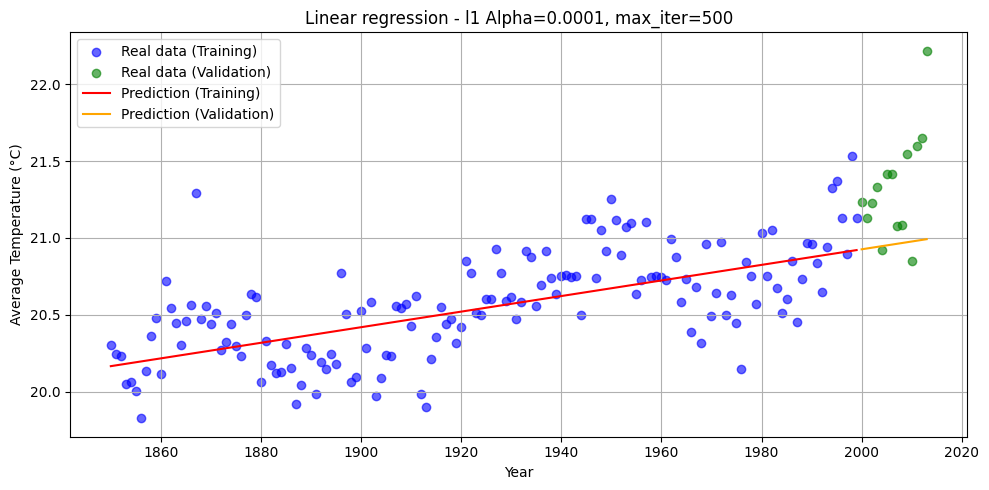

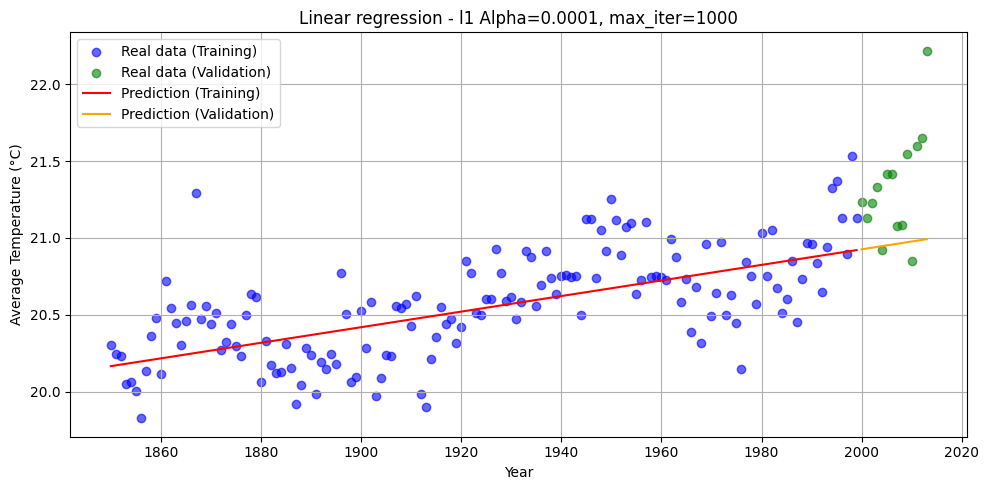

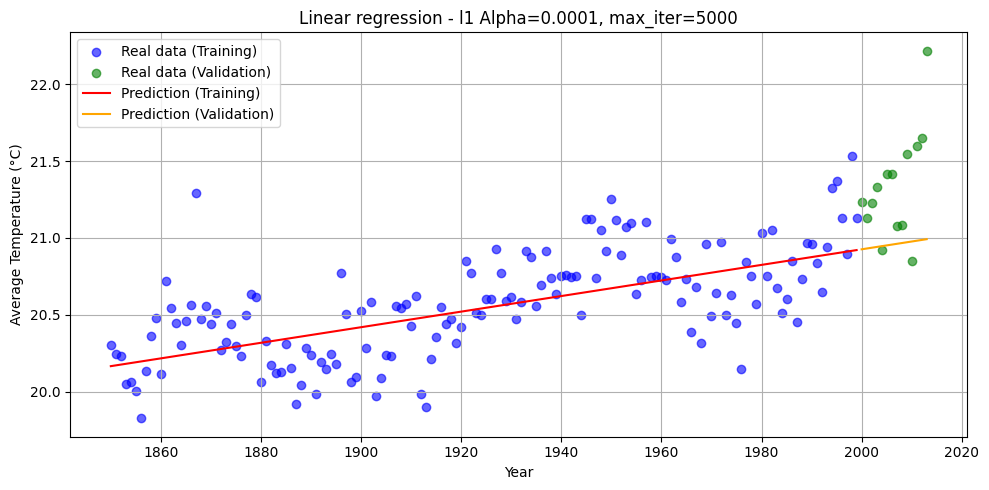

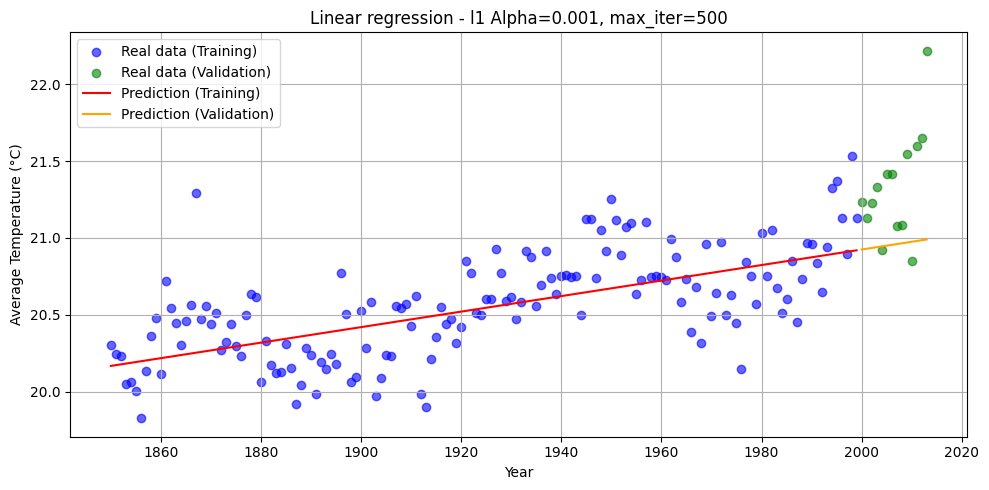

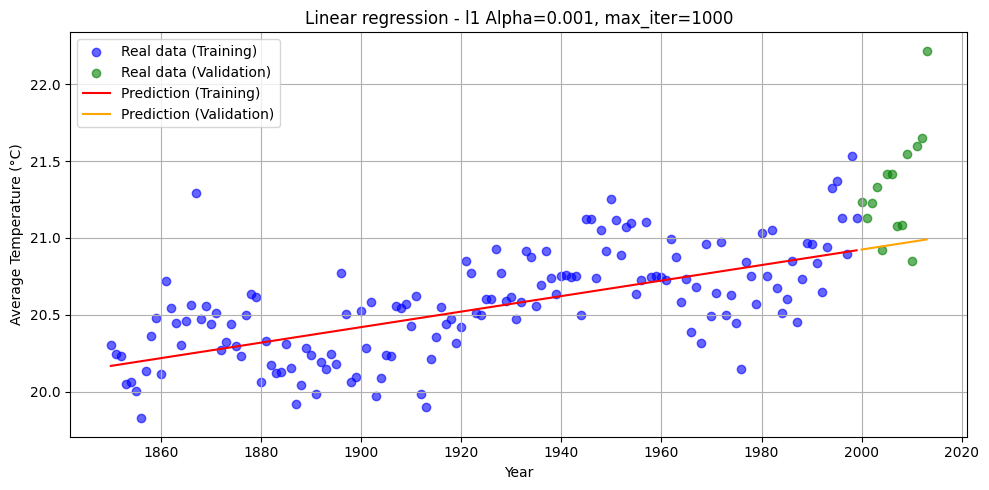

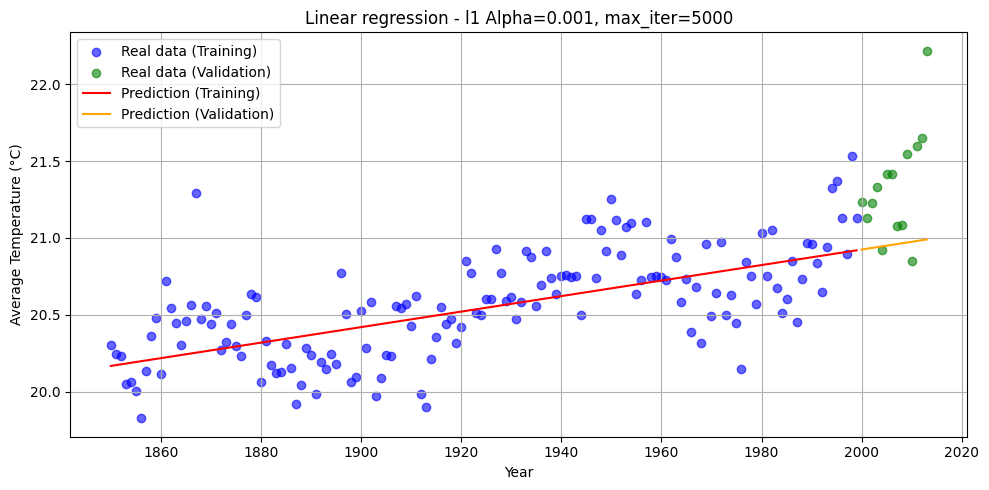

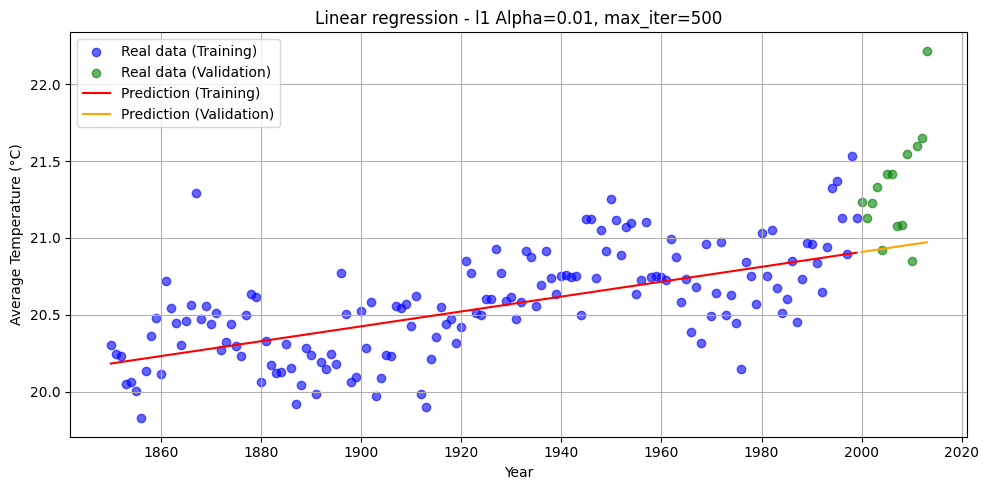

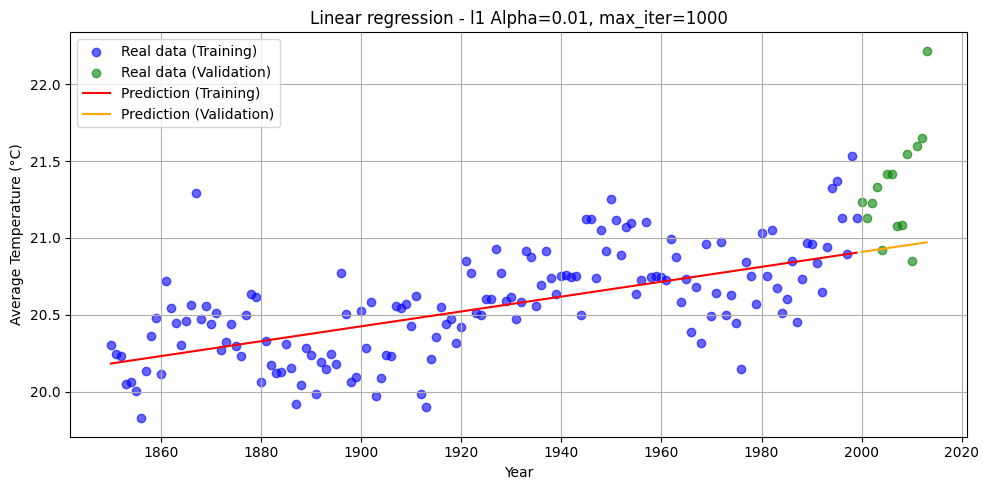

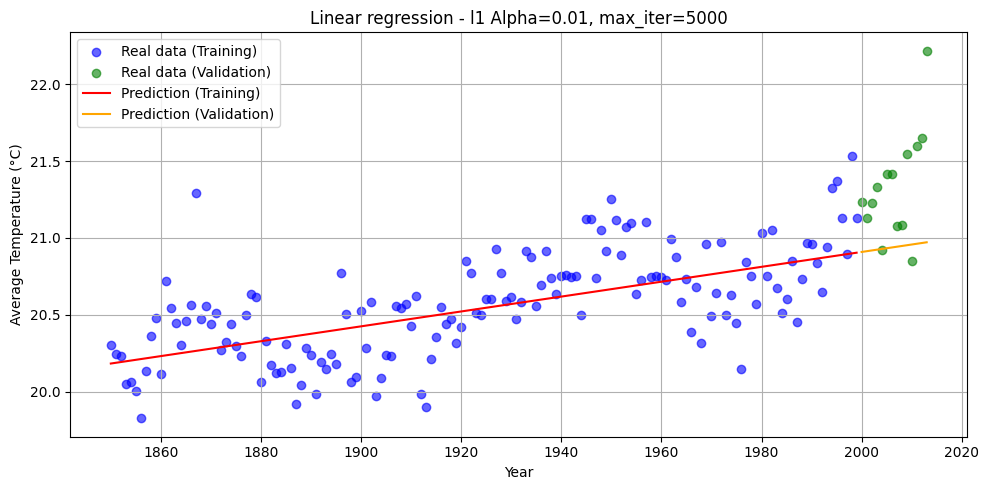

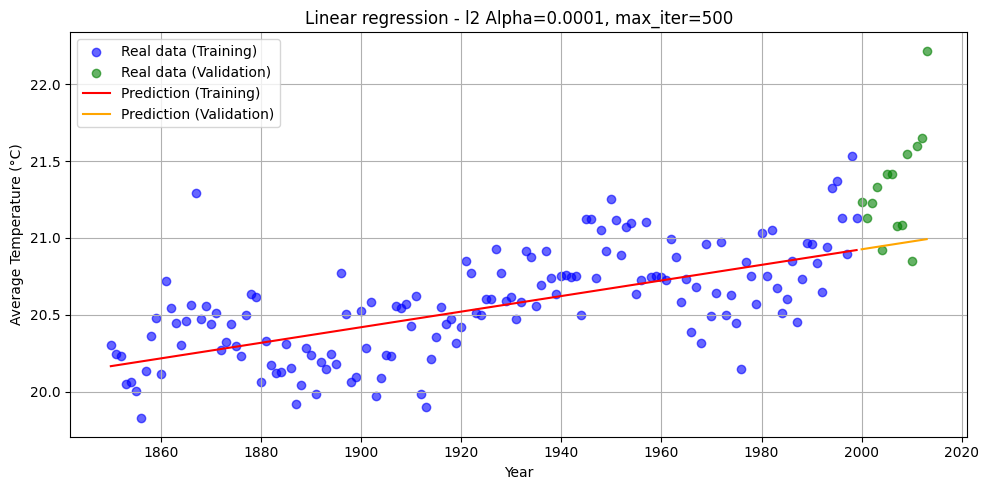

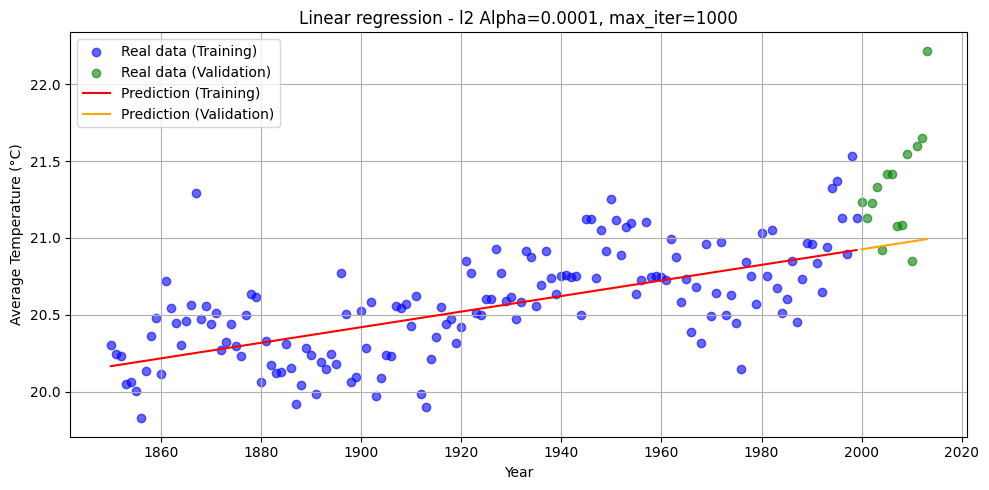

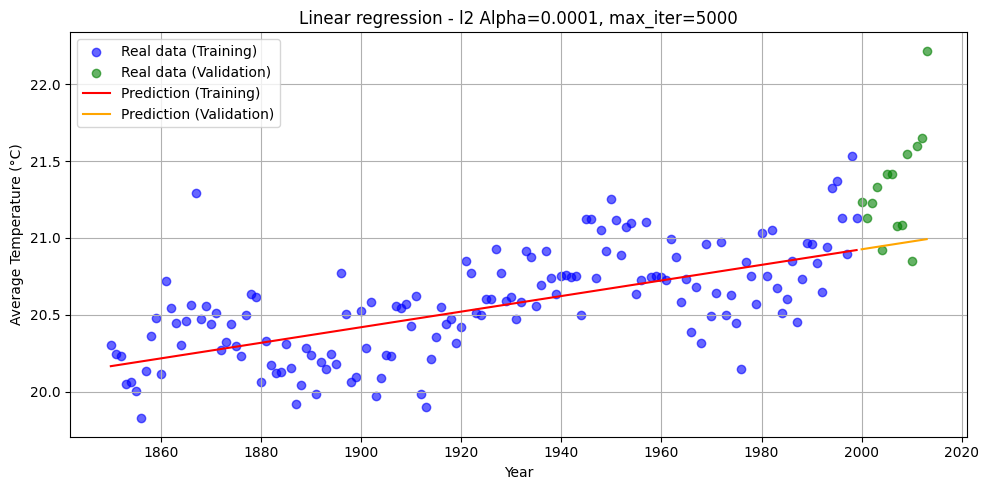

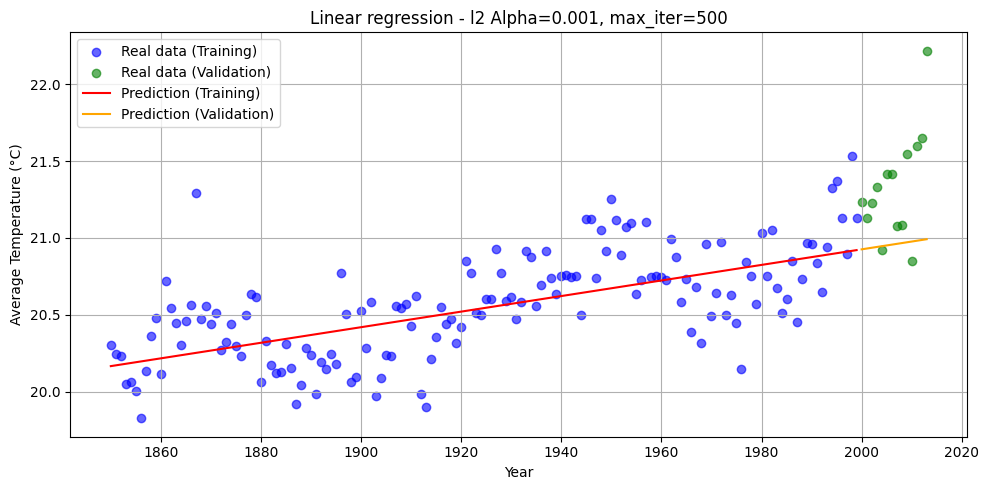

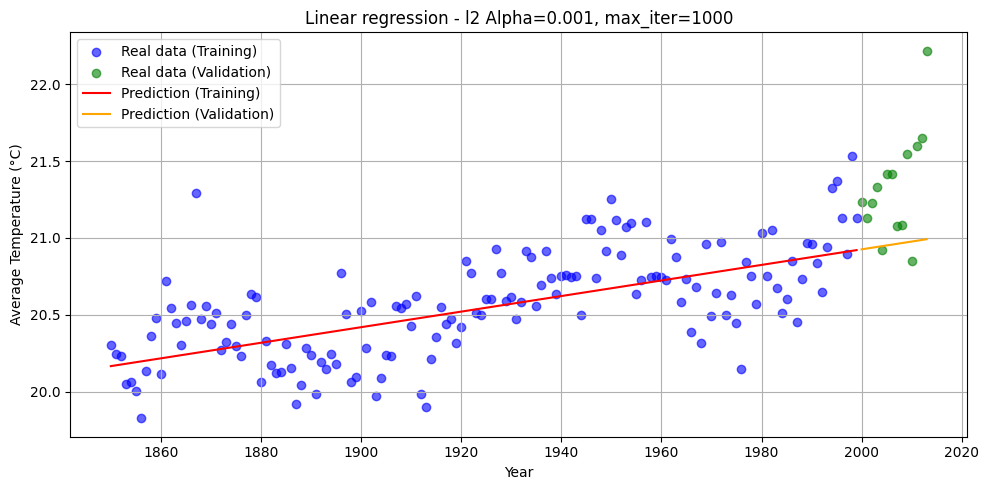

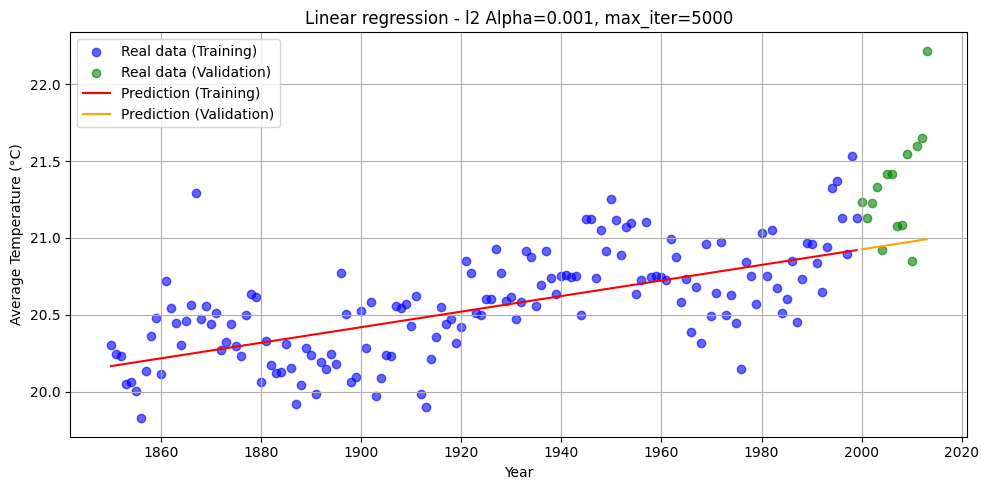

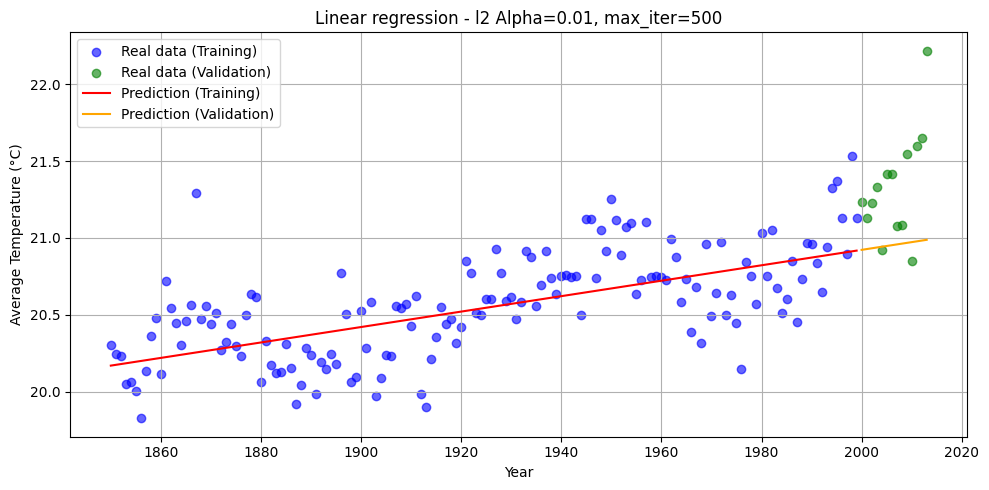

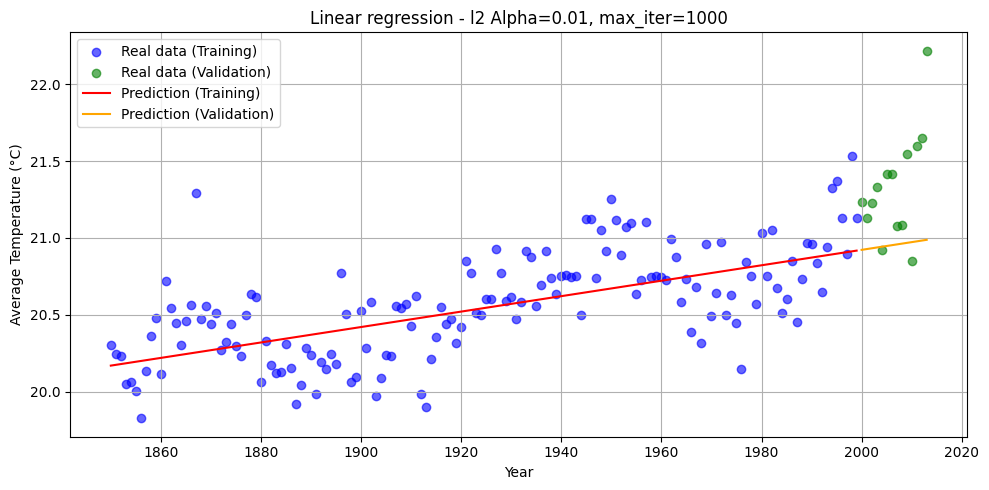

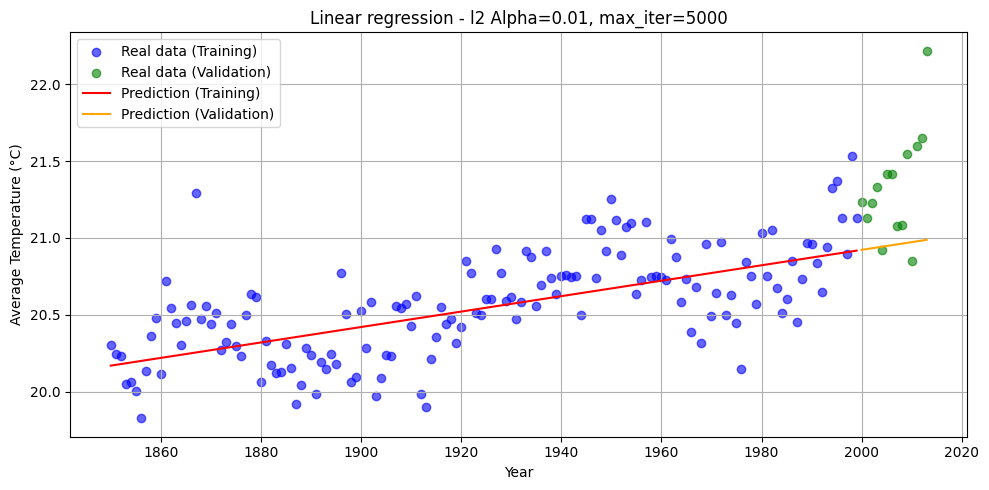

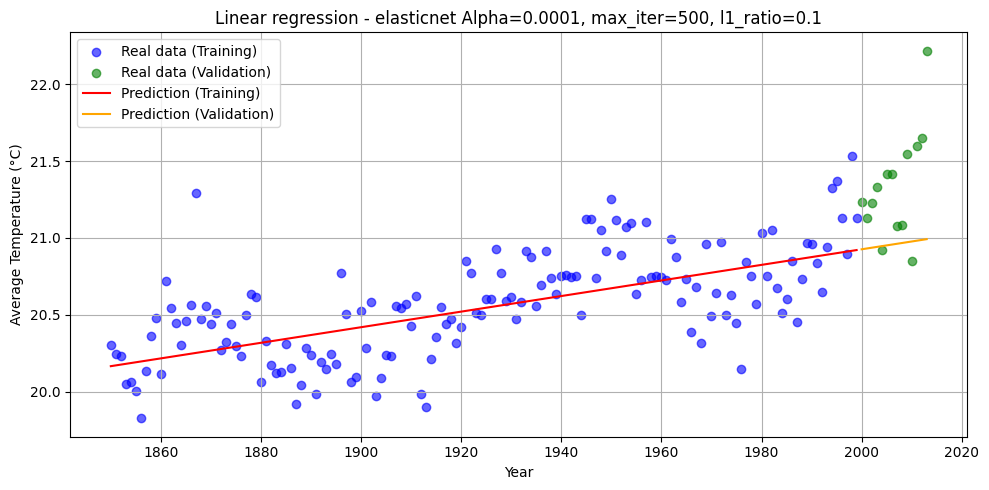

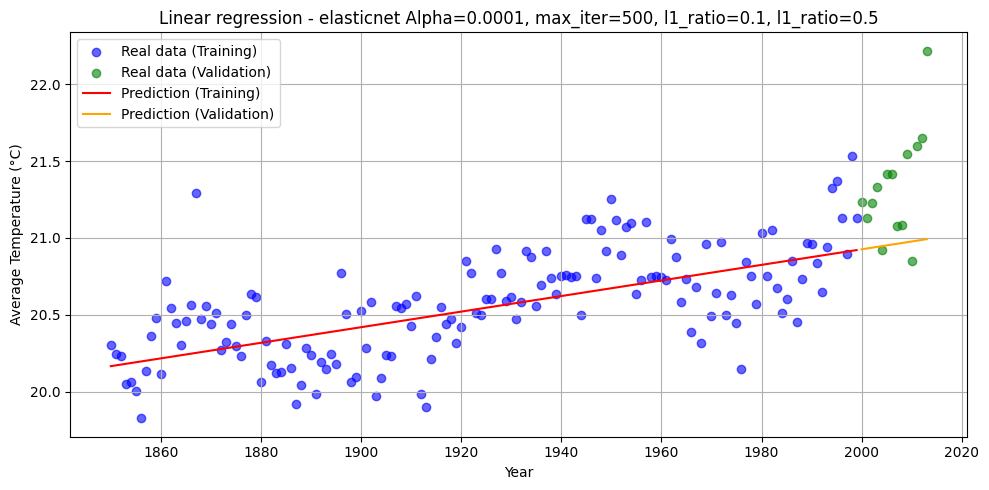

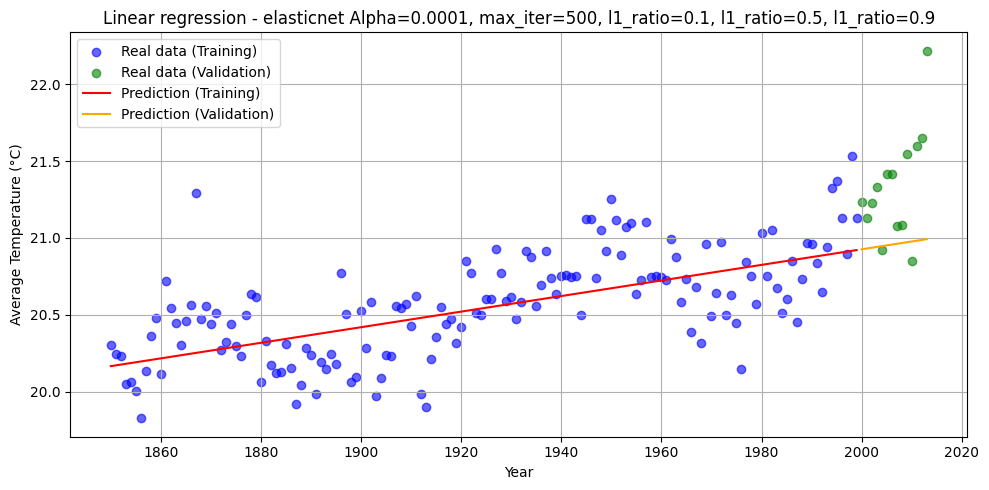

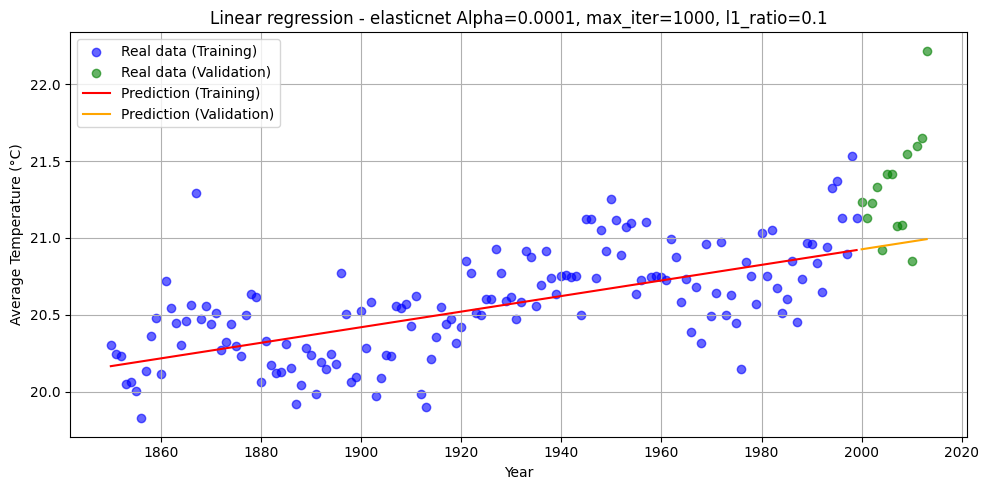

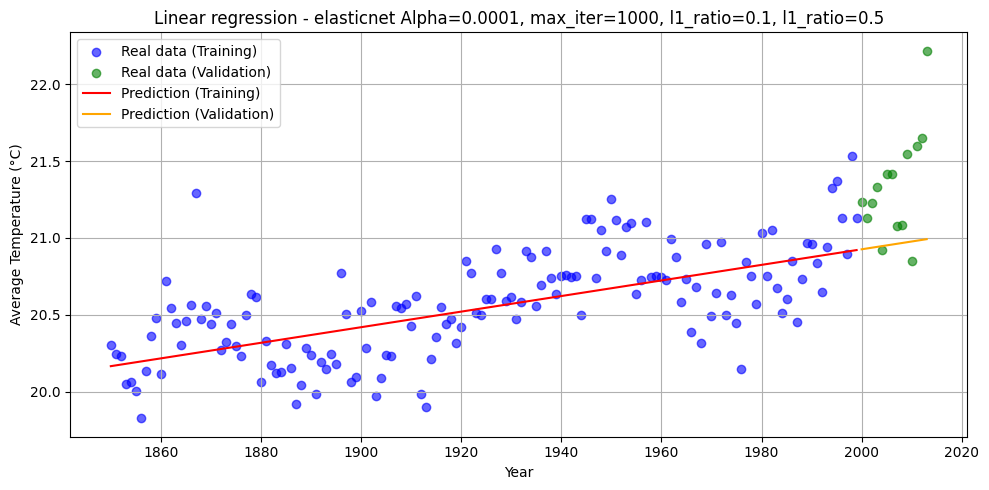

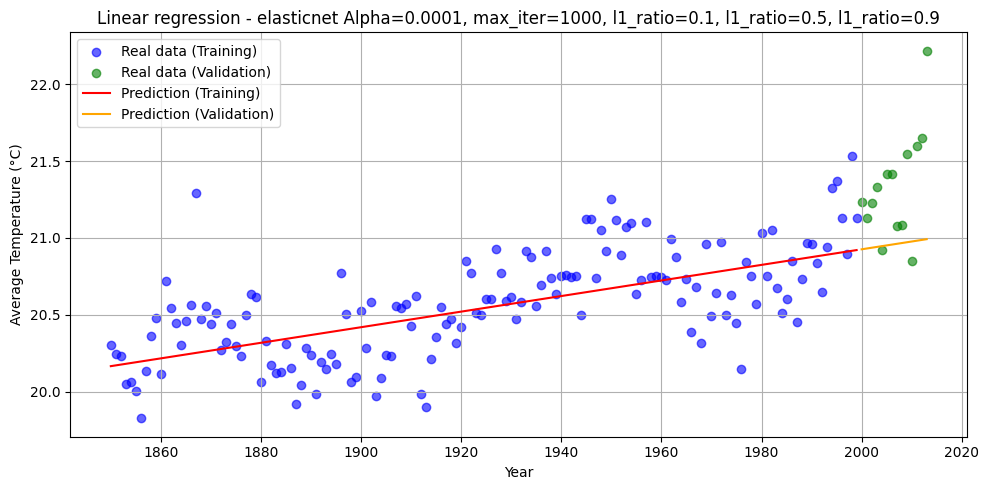

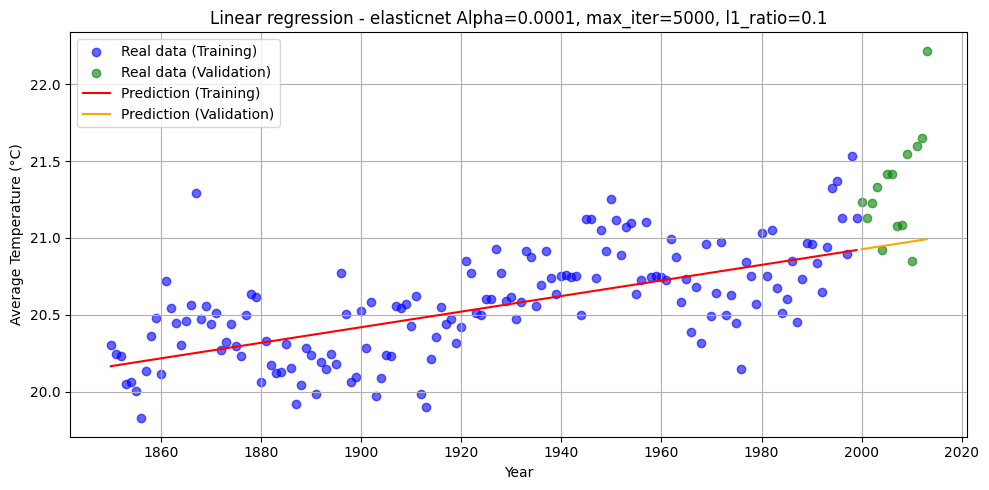

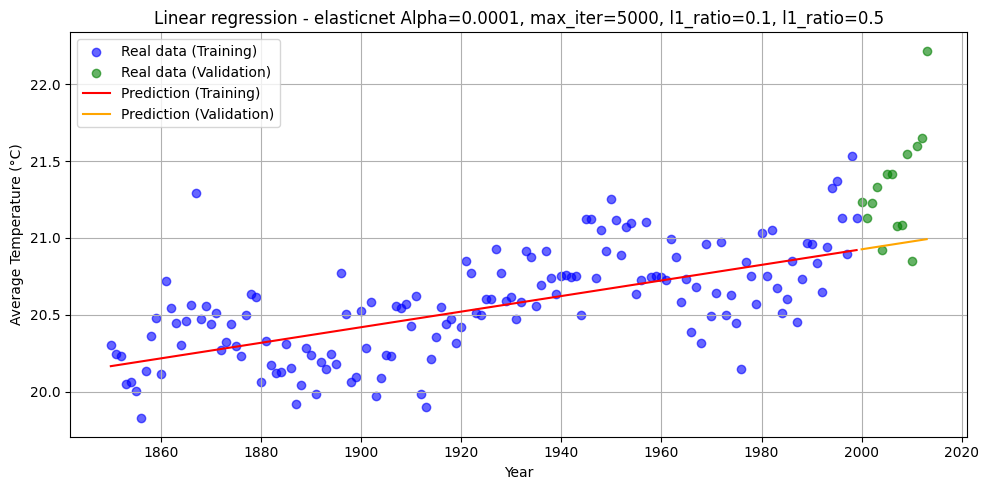

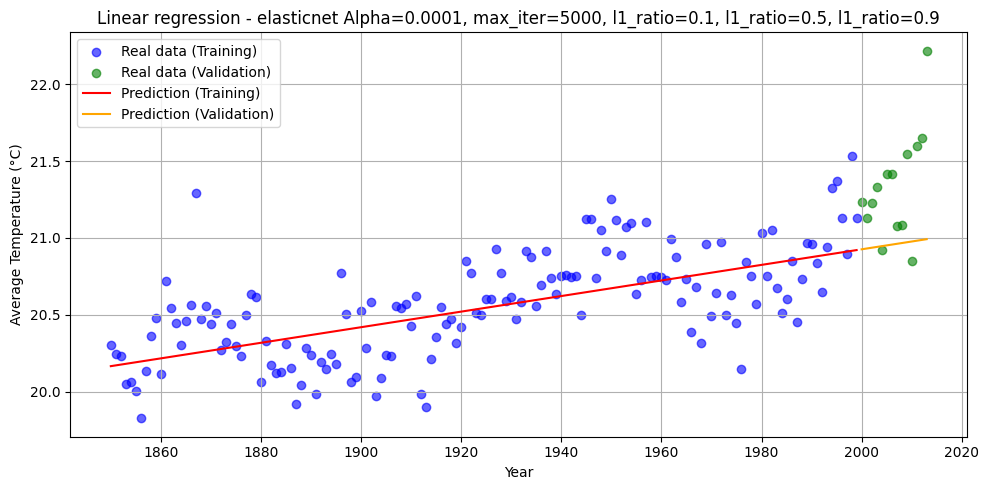

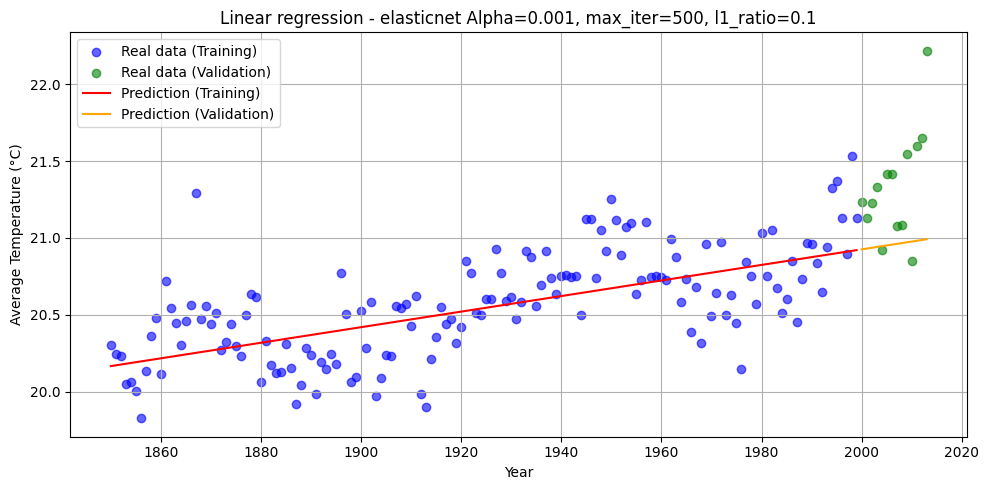

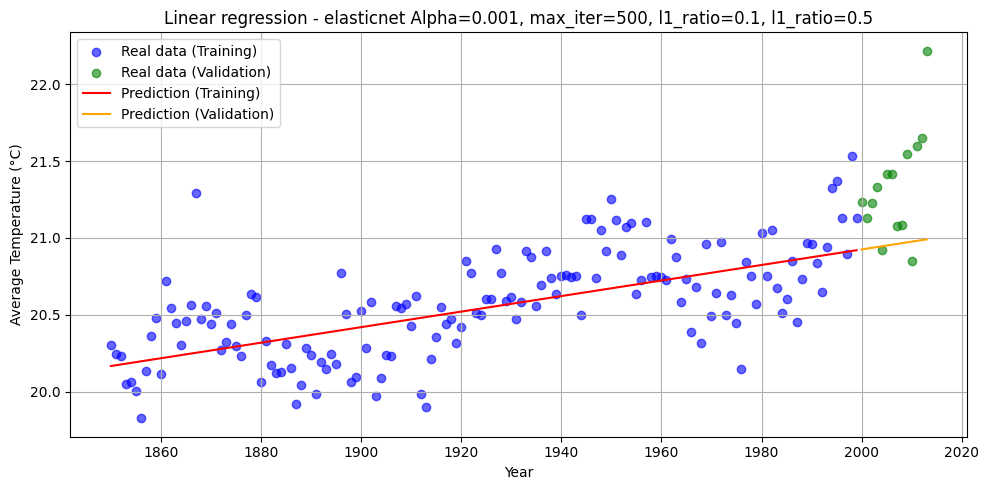

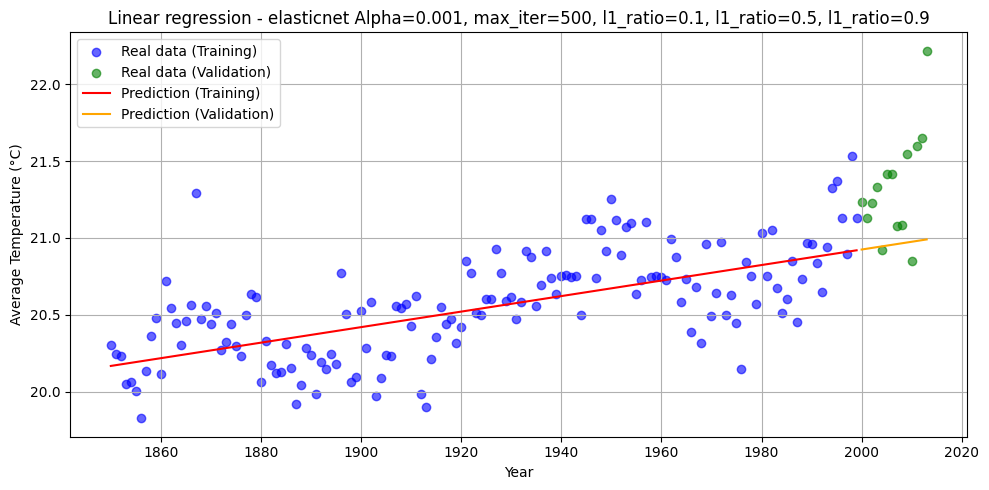

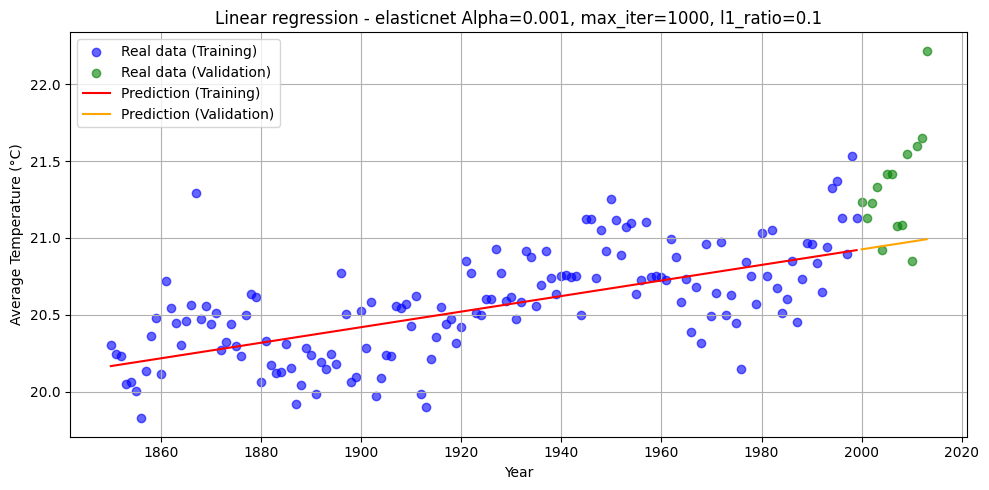

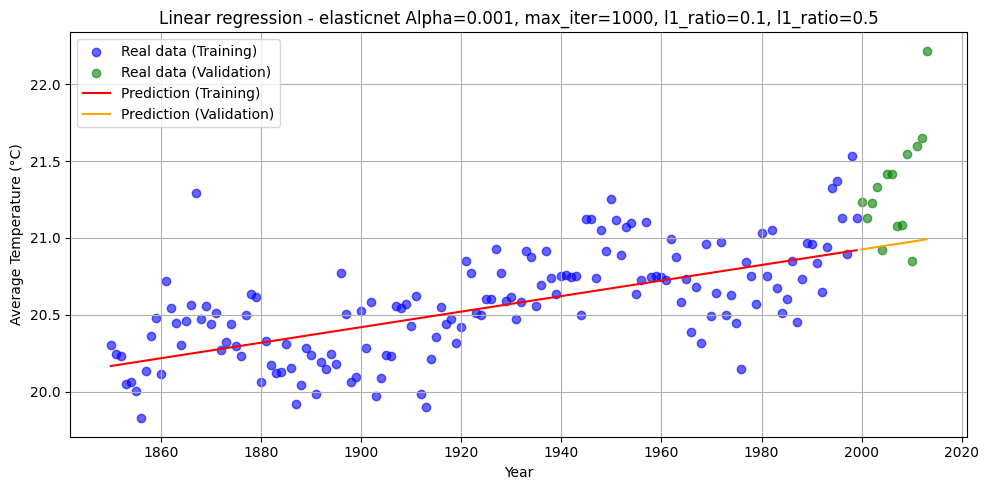

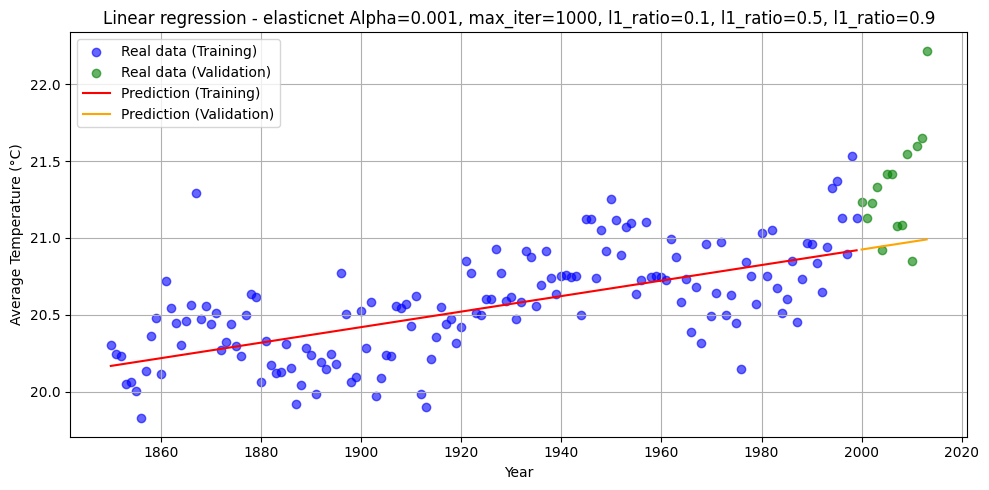

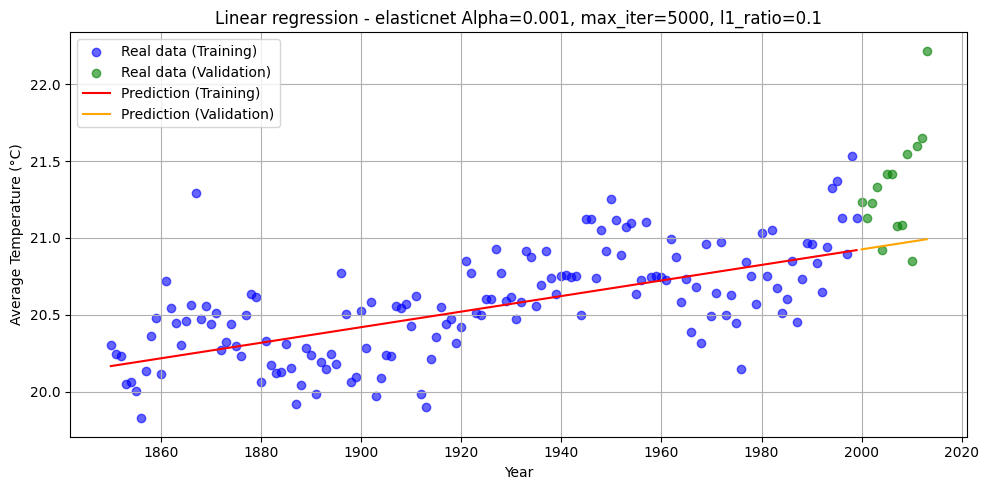

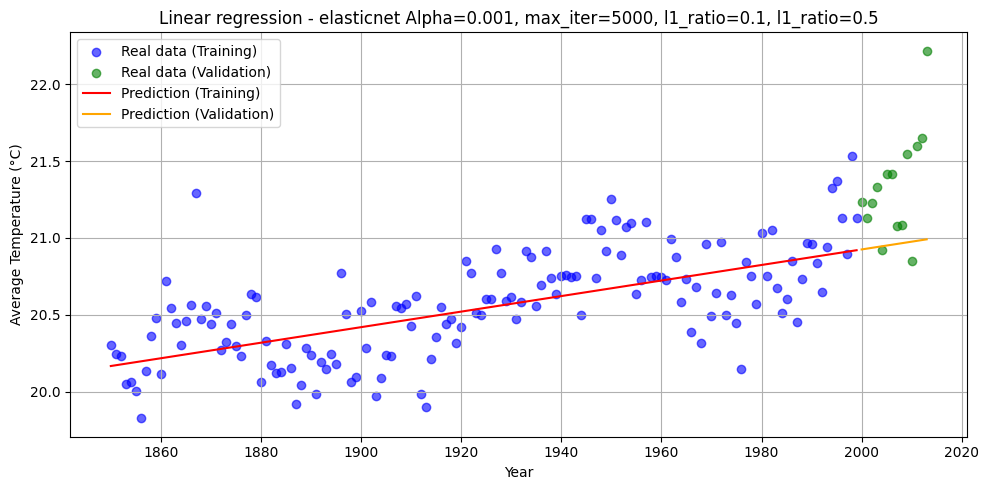

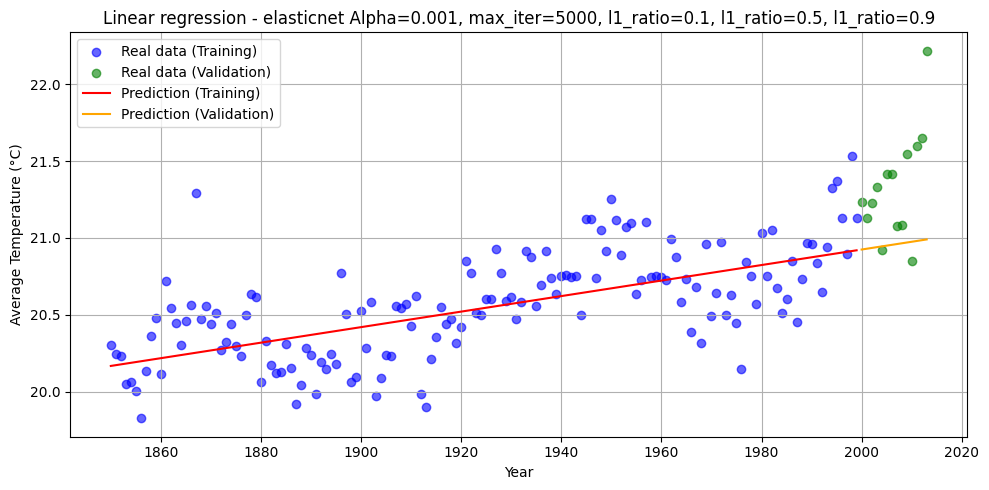

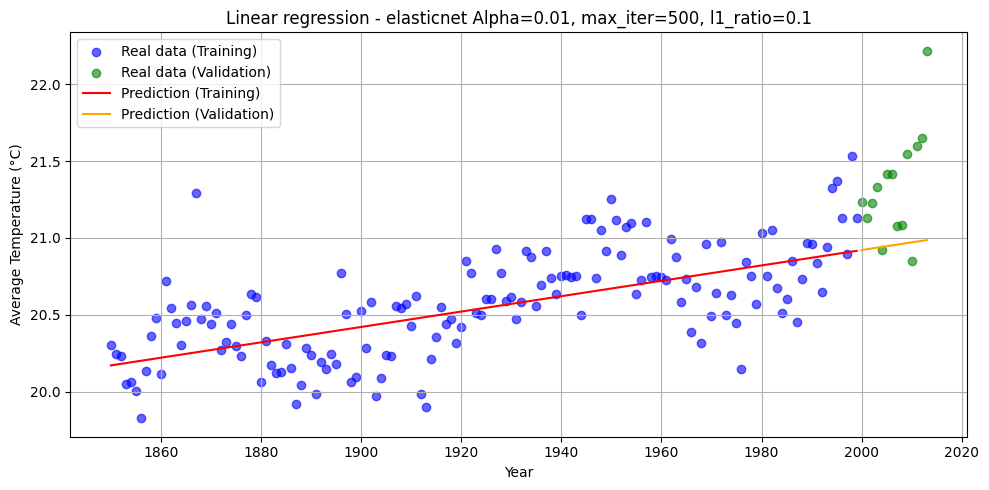

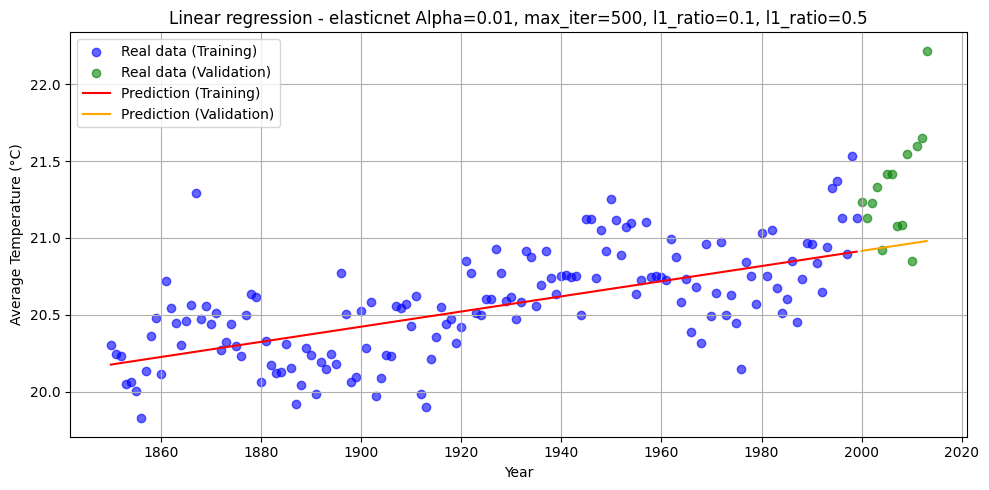

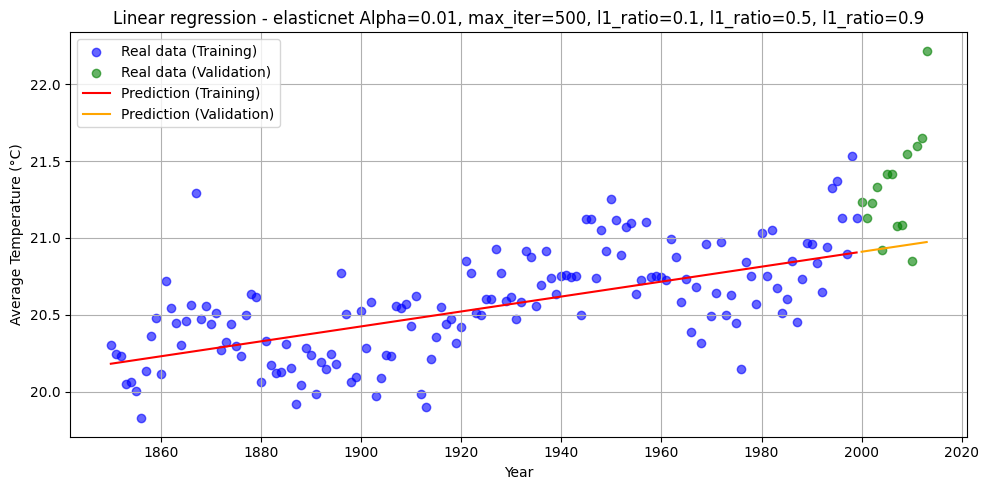

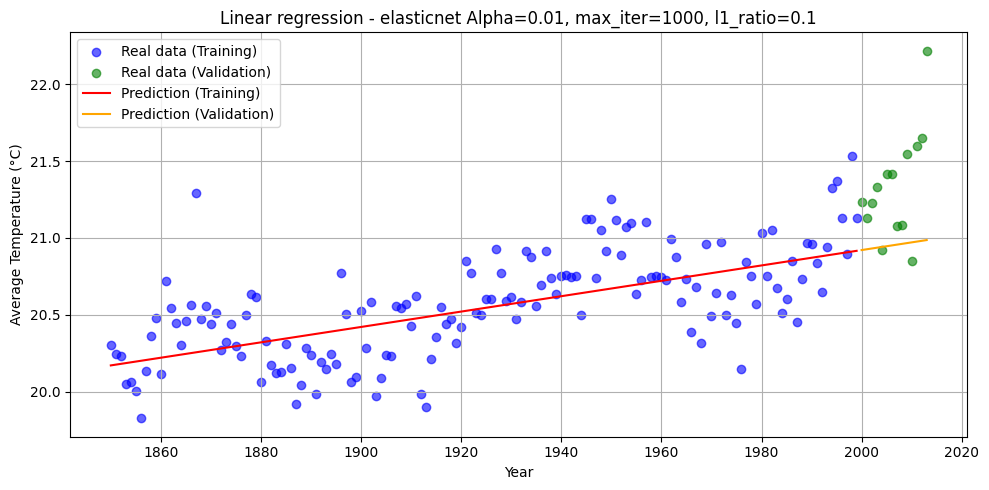

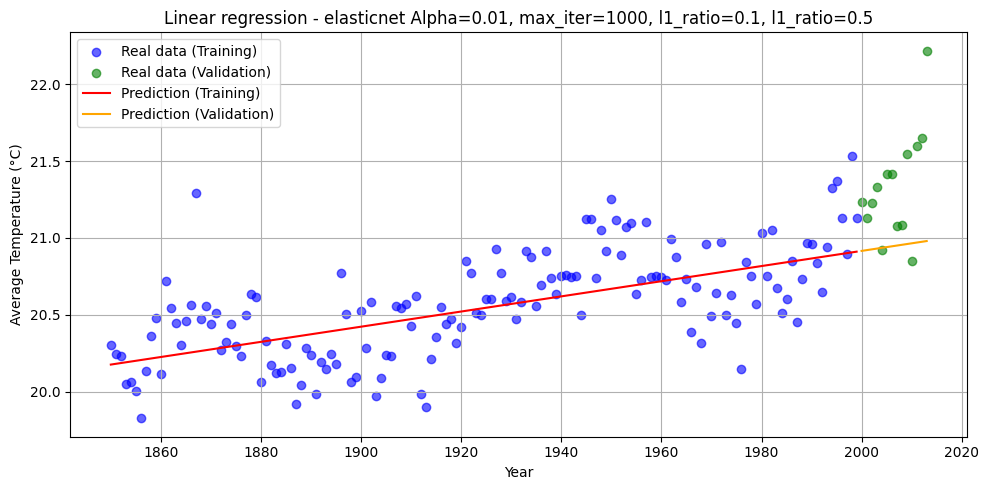

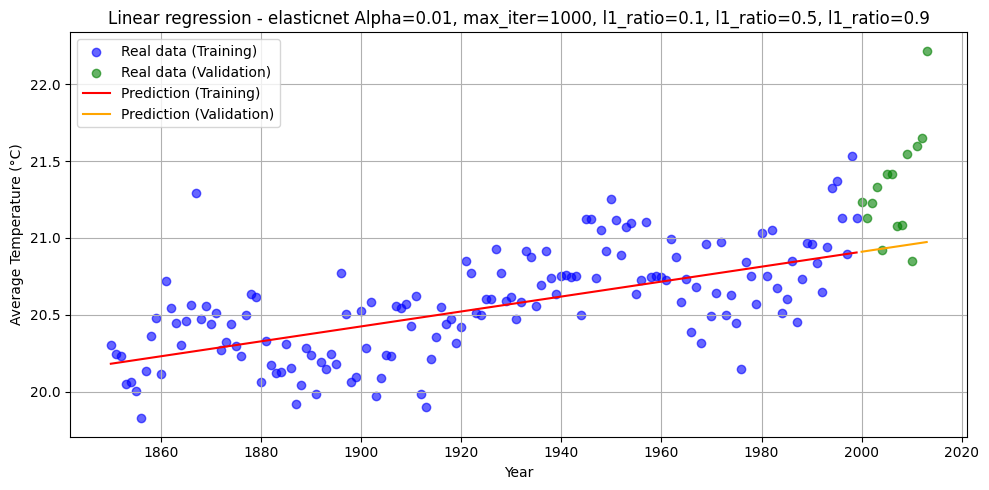

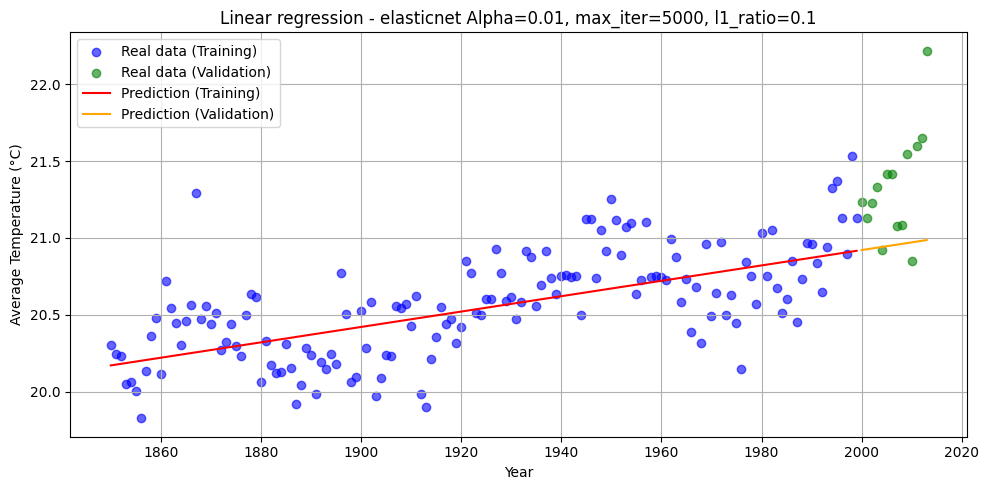

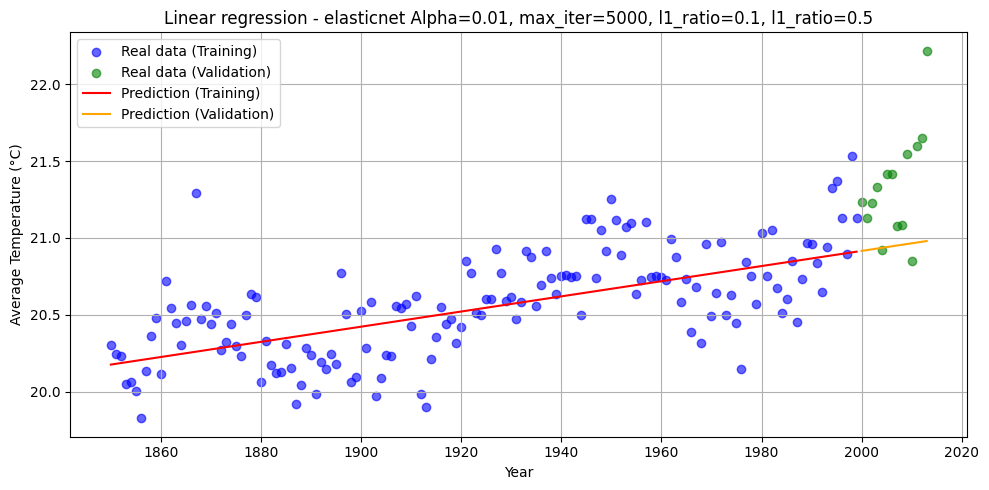

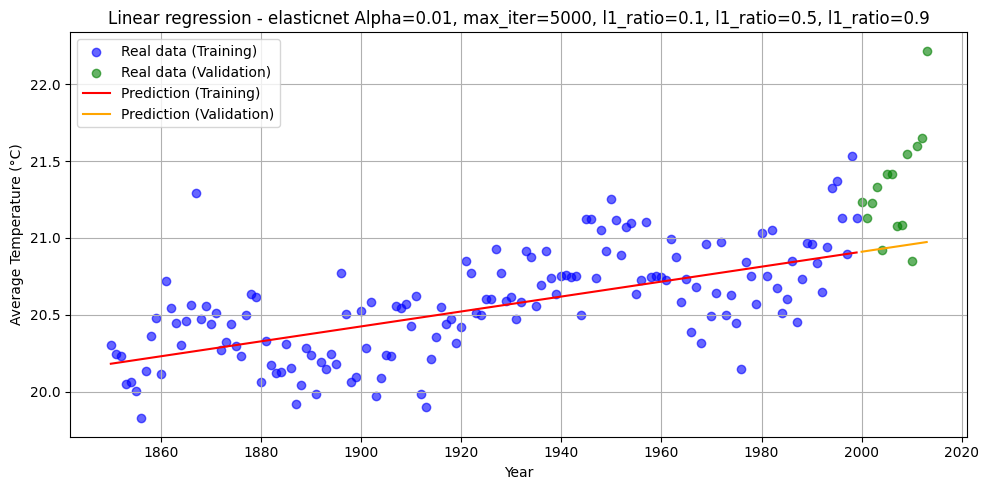

In [ ]:
# Go through all models
for result in models:
    label = result['label']
    y_pred_train = result['y_pred_train']
    y_pred_val = result['y_pred_val']


    plt.figure(figsize=(10, 5))


    plt.scatter(df_train['Year'], y_train, color='blue', label='Real data (Training)', alpha=0.6)
    plt.scatter(df_val['Year'], y_val, color='green', label='Real data (Validation)', alpha=0.6)


    plt.plot(df_train['Year'], y_pred_train, color='red', linestyle='-', label='Prediction (Training)')
    plt.plot(df_val['Year'], y_pred_val, color='orange', linestyle='-', label='Prediction (Validation)')

    # Chart settings
    plt.title(f'Linear regression - {label}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


    plt.show()

**5. Quantitatively evaluate all models using appropriate regression metrics. Compare results across configurations.**

In [ ]:
# Recalculate metrics for all models
for result in models:
    y_pred_train = result['y_pred_train']
    y_pred_val = result['y_pred_val']

    # Metrics for training set
    result['mse_train'] = mean_squared_error(y_train, y_pred_train)
    result['rmse_train'] = np.sqrt(result['mse_train'])
    result['mae_train'] = mean_absolute_error(y_train, y_pred_train)
    result['r2_train'] = r2_score(y_train, y_pred_train)

    # Metrics for validation set
    result['mse_val'] = mean_squared_error(y_val, y_pred_val)
    result['rmse_val'] = np.sqrt(result['mse_val'])
    result['mae_val'] = mean_absolute_error(y_val, y_pred_val)
    result['r2_val'] = r2_score(y_val, y_pred_val)

In [ ]:
# Create a DataFrame
summary = pd.DataFrame.from_records(models, columns=['label', 'mse_train', 'mse_val', 'r2_train', 'r2_val'])

# Rename columns
summary.rename(columns={
    'label': 'Modelo',
    'mse_train': 'MSE Train',
    'mse_val': 'MSE Val',
    'r2_train': 'R² Train',
    'r2_val': 'R² Val'
}, inplace=True)

# Sort by lowest MSE validation and display results
summary_sorted = summary.sort_values(by='MSE Val')
print(summary_sorted)

                                               Modelo  MSE Train   MSE Val  \
10                     l2 Alpha=0.0001, max_iter=1000   0.068100  0.249595   
11                     l2 Alpha=0.0001, max_iter=5000   0.068100  0.249595   
9                       l2 Alpha=0.0001, max_iter=500   0.068100  0.249595   
18  elasticnet Alpha=0.0001, max_iter=500, l1_rati...   0.068100  0.249606   
21  elasticnet Alpha=0.0001, max_iter=1000, l1_rat...   0.068100  0.249606   
24  elasticnet Alpha=0.0001, max_iter=5000, l1_rat...   0.068100  0.249606   
22  elasticnet Alpha=0.0001, max_iter=1000, l1_rat...   0.068100  0.249652   
25  elasticnet Alpha=0.0001, max_iter=5000, l1_rat...   0.068100  0.249652   
19  elasticnet Alpha=0.0001, max_iter=500, l1_rati...   0.068100  0.249652   
20  elasticnet Alpha=0.0001, max_iter=500, l1_rati...   0.068100  0.249697   
23  elasticnet Alpha=0.0001, max_iter=1000, l1_rat...   0.068100  0.249697   
26  elasticnet Alpha=0.0001, max_iter=5000, l1_rat...   0.068100

*Lower alpha  and L2 penalty yield the best validation performance, but all models overfit significantly, as shown by the large gap between training and validation metrics. The training R² is positive , but the validation R² is negative, indicating that the model fits the training data well but does not generalize to new data.*

In [ ]:
# Choose the model with the best metrics
best_model = min(models, key=lambda r: (r['mse_val'] + r['mse_train']) / 2)

print(f"\n Best model: {best_model['label']} with MSE Val = {best_model['mse_val']:.4f}")


 Best model: l2 Alpha=0.0001, max_iter=500 with MSE Val = 0.2496


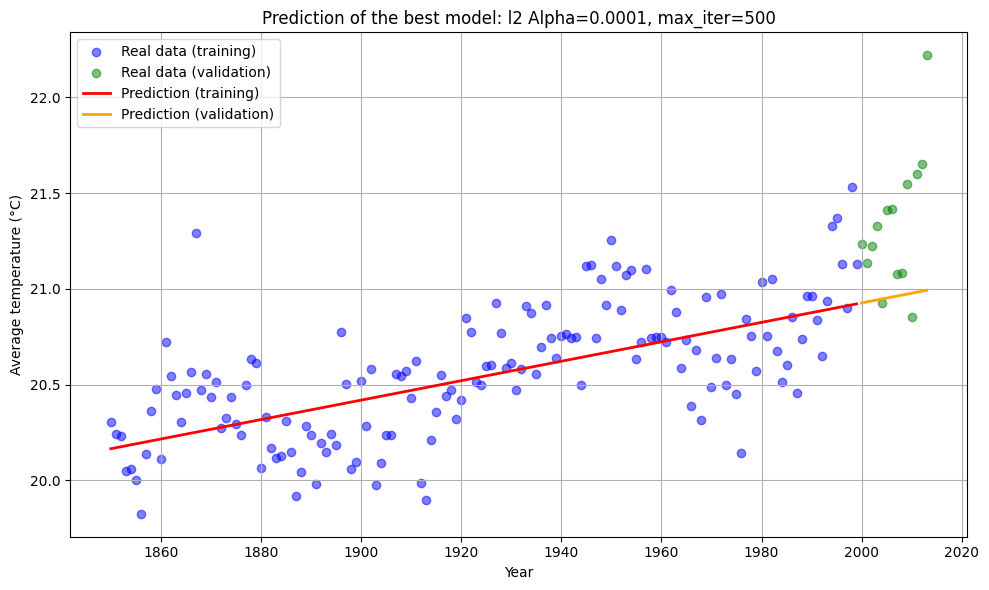

In [ ]:
# Data from the best model obtained
label = best_model['label']
y_pred_train = best_model['y_pred_train']
y_pred_val = best_model['y_pred_val']

# Years used for each set
years_train = df_train['Year']
years_val = df_val['Year']


plt.figure(figsize=(10, 6))

# Real data
plt.scatter(years_train, y_train, color='blue', label='Real data (training)', alpha=0.5)
plt.scatter(years_val, y_val, color='green', label='Real data (validation)', alpha=0.5)

# Predictions
plt.plot(years_train, y_pred_train, color='red', label='Prediction (training)', linewidth=2)
plt.plot(years_val, y_pred_val, color='orange', label='Prediction (validation)', linewidth=2)

# Tags and legend
plt.title(f'Prediction of the best model: {label}')
plt.xlabel('Year')
plt.ylabel('Average temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#**Part C: Prediction**

**1. Re-train the regression model using the best hyperparameters found previously, this time considering the entire data set up to 2015 as the training set.**

In [ ]:
# Training with data from 1850 to 2015
df_full_train = df_avg_mexico[df_avg_mexico['Year'] <= 2015].copy()

X_full = df_full_train[['Year']]
y_full = df_full_train['AverageTemperature']

In [ ]:
# Rescale the data to years
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

In [ ]:
# Indicate the best parameters for the model
penalty = 'l2'
alpha = 0.0001
max_iter = 500

In [ ]:
# Training the final model
best_model_final = SGDRegressor(
    penalty=penalty,
    alpha=alpha,
    max_iter=max_iter,
    loss='squared_error',
    random_state=42
)

best_model_final.fit(X_full_scaled, y_full)

SGDRegressor(max_iter=500, random_state=42)

2. Generate annual average temperature predictions for the period from 2016 to 2100 using the trained model. Be sure to apply the same scaling transformation to the new data before making predictions.

In [ ]:
# Generate a DataFrame with future years
future_years = pd.DataFrame({"Year": range(2016, 2101)})

# Apply the scaling transformation
future_years["Year_scaled"] = scaler.transform(future_years[["Year"]])

# Generate predictions with the trained model
future_years["PredictedTemperature"] = best_model_final.predict(future_years[["Year_scaled"]])

# Show the first and last predictions
print(future_years.head())
print(future_years.tail())

   Year  Year_scaled  PredictedTemperature
0  2016     1.784890             21.127279
1  2017     1.806013             21.133392
2  2018     1.827136             21.139505
3  2019     1.848259             21.145619
4  2020     1.869382             21.151732
    Year  Year_scaled  PredictedTemperature
80  2096     3.474727             21.616344
81  2097     3.495850             21.622457
82  2098     3.516973             21.628571
83  2099     3.538096             21.634684
84  2100     3.559219             21.640797


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SGDRegressor was fitted without feature names



**3. Graph the evolution of the projected average annual temperature from 2016 to 2100. Visually analyze whether you observe an increasing, decreasing, or stable trend over time. Justify your answer based on the graph**.

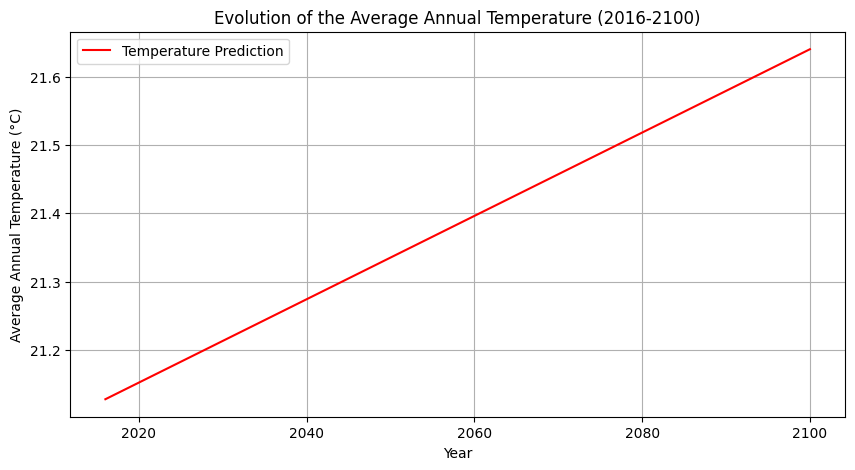

In [ ]:
# Create the graph
plt.figure(figsize=(10, 5))
plt.plot(future_years["Year"], future_years["PredictedTemperature"], color="red", label="Temperature Prediction")

# Tags and title
plt.xlabel("Year")
plt.ylabel("Average Annual Temperature (°C)")
plt.title("Evolution of the Average Annual Temperature (2016-2100)")
plt.grid(True)
plt.legend()
plt.show()

The graph shows the evolution of the mean annual temperature from 2016 to 2100. An increasing trend is observed over time, as the red temperature prediction line presents a positive slope and increases continuously.

**Justification:**

*   The annual mean temperature starts at approximately 21.2°C in 2016 and rises to 21.6°C in 2100.
*   The upward direction of the red line indicates that over the years the temperature is steadily increasing.







#**Part D: Conclusions**

1. Visually and analytically compare the prediction against historical behavior.

In [ ]:
# Create figure
fig = go.Figure()

# Real historical data (1850–2015)
fig.add_trace(go.Scatter(
    x=X_full['Year'], y=y_full,
    mode="lines", line=dict(color="blue", width=2),
    name="Real Data (1850–2015)"
))

# Future predictions (2016–2100)
fig.add_trace(go.Scatter(
    x=future_years['Year'], y=future_years['PredictedTemperature'],
    mode="lines", line=dict(color="orange", width=2),
    name="Future Prediction (2016–2100)"
))

# Layout settings
fig.update_layout(
    title="Evolution and Prediction of Annual Average Temperature in Mexico (1850–2100)",
    xaxis_title="Year",
    yaxis_title="Average Temperature (°C)",
    legend=dict(x=0, y=1),
    template="plotly_white"
)

# Show interactive plot
fig.show()


**2. Explanation of the Solution:**

**Analysis of the Increase in Mexico's Average Temperature**.

The objective of this project was to determine if the average temperature in Mexico has increased, using historical data from 1850 to 2015 and validating a future projection from 2016 to 2100.

**Data Processing**

To address this question, first the *GlobalLandTemperaturesByCountry.csv* database, extracted from Kaggle, was processed. The **Pandas** library was used, loading the dataset with *pd.read_csv*() into a variable named *df.* To explore its structure, *df.head()* was used, identifying the following key columns:

* dt
* AverageTemperature
* AverageTemperatureUncertainty
* Country

The data set covers records since 1743, but has numerous null values (*NaN*). Therefore, the analysis started from 1850, where the data are more consistent.

During the cleaning of the dataset, it was observed that the dates did not have a uniform format, as different countries have variations in their presentation. To solve this, the *dt* column was converted to **datetime** format, ensuring a uniform format for correct year extraction in subsequent steps.

Subsequently, a new column called *Year*, derived from *dt*, was created to facilitate the analysis of the average temperature per year.

**Comparison of Average Temperatures**.

To contextualize the changes in Mexico, a comparison was made with **United States and Brazil.** Annual averages were calculated using *.mean()*, transforming daily data into annual values to improve the understanding of trends.

Interactive graphs with **Plotly Express** were used to visualize the evolution of temperatures in the countries analyzed. For linear regression model tests, Matplotlib was used, optimizing computational performance in cases where **Plotly Express** generated high-resolution images that did not load correctly.

**Training of Predictive Models**.

To train the linear regression models, the data set was delimited:

* Training data: 1850 - 1999
* Validation data: 2000 - 2015

The **SGDRegressor** model from *scikit-learn* was used, according to the established specifications.

Prior to training, **StandardScaler** was applied to scale the *Year* values in the training and validation sets. Then, hyperparameters were defined to evaluate the performance of the models:

* alpha_vals = [0.0001, 0.001, 0.01]
* max_iter_vals = [500, 1000, 5000]
* l1_ratios = [0.1, 0.5, 0.9]
* penalties = [“l1”, “l2”, “elasticnet”]

Combinations of these hyperparameters were iterated to identify the best model using key metrics such as **mean squared error (MSE)** and **R²**, evaluating each combination with plots generated in **Matplotlib**.

**Optimization and Future Prediction**.

The optimal model, based on the **MSE** average, was obtained with the following parameters:

* penalty = 'l2'
* alpha = 0.0001
* max_iter = 500

We proceeded to re-train the model using the full period (1850-2015), applying the previously obtained parameters. Then, a new *dataframe* was created to make predictions from **2016 to 2100**, keeping the scale of the years to preserve the consistency of the data.

Finally, the **model prediction** was plotted, obtaining an upward trend in temperature, indicating a constant increase.

**Conclusions**

The evidence obtained confirms that the average temperature in Mexico has increased and will continue to rise according to the projections made. The final visualization shows the temperature evolution from 1850 to 2015, followed by the prediction for **2016-2100**, highlighting that warming will continue in the future.

**Challenges Encountered**

1.	**Inconsistent date format**: Initially, the lack of uniformity in the *dt* column generated errors until conversion to **datetime** format was applied.

2.	**Evaluation of key metrics**:

* An effective linear regression typically exhibits an **R² close to 1**.
* In the training data, **R²** reached approximately **0.5**, while in validation, the values were **negative in all cases**.
* After investigating this anomaly, it was determined that the temperature peaks in the data show large variations, which explains the results obtained.

Despite these challenges, the analysis clearly demonstrates the **increasing trend of temperature in Mexico**.















